# Power Consumption prediction ( PowerConsumption_Zone2 as a target)

In [1]:
 #Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load data**


In [37]:
df = pd.read_csv('/content/powerconsumption.csv')
df.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


**transforming DateTime column into index**

In [38]:

df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

# **Features Creation**

In [39]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

**Calculating moving average**


In [40]:

df['SMA30'] = df['PowerConsumption_Zone2'].rolling(30).mean()
df['SMA15'] = df['PowerConsumption_Zone2'].rolling(15).mean()

**input and target variable**

In [41]:
X_train = df.loc[:'10-01-2017',['Temperature','dayofyear', 'hour', 'dayofweek', 'SMA30', 'SMA15']]
y_train = df.loc[:'10-01-2017', ['PowerConsumption_Zone2']]
X_test = df.loc['10-01-2017':,['Temperature','dayofyear', 'hour', 'dayofweek', 'SMA30', 'SMA15']]
y_test = df.loc['10-01-2017':, ['PowerConsumption_Zone2']]

**Predictions**

the algorithm used is Gradient Boosting (**xgboost**)

In [42]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1500,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=6,
                       learning_rate=0.03, 
                       random_state = 48)
reg.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],verbose=100)

[23:33:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:20429.5	validation_1-rmse:22706.6
[100]	validation_0-rmse:1248.76	validation_1-rmse:1845.03
[200]	validation_0-rmse:622.463	validation_1-rmse:1221.7
[300]	validation_0-rmse:580.622	validation_1-rmse:1185.52
[400]	validation_0-rmse:553.957	validation_1-rmse:1178.85
[500]	validation_0-rmse:531.867	validation_1-rmse:1173.68
[600]	validation_0-rmse:514.982	validation_1-rmse:1186.09
[700]	validation_0-rmse:497.932	validation_1-rmse:1201.13
[800]	validation_0-rmse:483.109	validation_1-rmse:1208.29
[900]	validation_0-rmse:470.789	validation_1-rmse:1220.53
[1000]	validation_0-rmse:461.789	validation_1-rmse:1225.66
[1100]	validation_0-rmse:450.965	validation_1-rmse:1223.67
[1200]	validation_0-rmse:441.138	validation_1-rmse:1233.59
[1300]	validation_0-rmse:431.816	validation_1-rmse:1247.25
[1400]	validation_0-rmse:422.87	validation_1-rmse:1251.89
[1

XGBRegressor(early_stopping_rounds=50, learning_rate=0.03, max_depth=6,
             n_estimators=1500, random_state=48)

**Important factors**

In [43]:
fi = pd.DataFrame(data=reg.feature_importances_,index=X_train.columns,columns=['importance'])

In [44]:
fi

,importance
Temperature,0.003447
dayofyear,0.011213
hour,0.109062
dayofweek,0.005677
SMA30,0.012643
SMA15,0.857958


**Results**

In [45]:
y_test = pd.DataFrame(y_test)
y_test['prediction'] = reg.predict(X_test)
y_test

,PowerConsumption_Zone2,prediction
Datetime,,
2017-10-01 00:00:00,17985.06224,17522.781250
2017-10-01 00:10:00,17611.61826,17320.009766
2017-10-01 00:20:00,17148.54772,17233.814453
2017-10-01 00:30:00,16827.38589,17162.353516
2017-10-01 00:40:00,16621.99170,16866.742188
...,...,...
2017-12-30 23:10:00,26857.31820,24747.832031
2017-12-30 23:20:00,26124.57809,24470.710938
2017-12-30 23:30:00,25277.69254,23935.826172


In [46]:
df = df.merge(y_test[['prediction']], how='left', left_index=True, right_index=True)

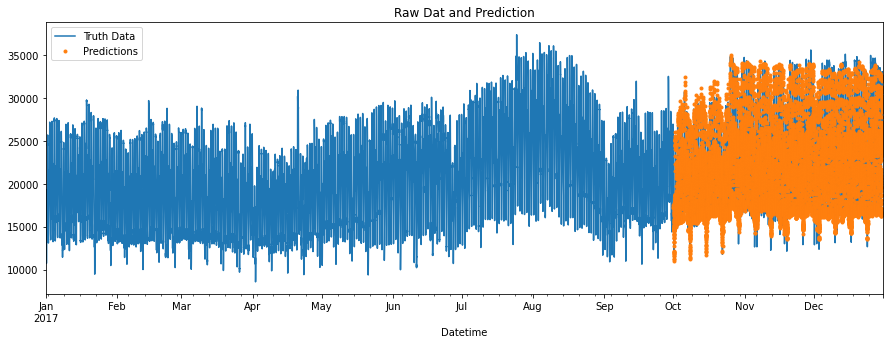

In [47]:
ax = df[['PowerConsumption_Zone2']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [50]:
from sklearn.metrics import r2_score
r2_score(y_test['PowerConsumption_Zone2'], y_test['prediction'])

0.9444716410186955

94% of the observed data can be explained by our model means good result

In [49]:
score = np.sqrt(mean_squared_error(y_test['PowerConsumption_Zone2'], y_test['prediction']))
print(f'RMSE Score : {score:0.2f}')

RMSE Score : 1261.49
